In [1]:
# finetuning llama2

In [2]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

full_lora_layers = [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]


def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#init model

model_size=13
#model_size=7
model_size=70
r=32
lora_alpha=32
bit=16
bit=4
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]
#target_modules=[]
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"


#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


Using 4-bit mode


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:

pipe = pipeline("text-generation", model=model,
                tokenizer=tokenizer, max_new_tokens=1000)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [ ]:
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240102best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(1874, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [ ]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction="",prefix="Example"):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#{prefix} Data
##Name: {name}
##SMILES: {smiles} 
##Reason: {reason}
##Prediction: {prediction}
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id],prefix="Test")
#    prompt+="""
##Output: Reason, Prediction
#    """

    return prompt

In [ ]:
#fineturning
from datasets import Dataset


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [ ]:
#はじめのN件をテストデータにする
n_test=100

train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map: 100%|██████████| 1774/1774 [00:00<00:00, 5724.50 examples/s]


In [ ]:
import transformers
from datetime import datetime

gradient_checkpointing = False
per_device_train_batch_size=1
epochs=2
lr=10**-5
do_train=True
#do_train=False

#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.744700
200,1.277000
300,1.144700
400,1.094200
500,1.061600
600,0.999300
700,1.024200
800,1.015600
900,1.016900
1000,1.011300


In [ ]:

import re
def ask_value(prompt,pipe):
    res=pipe(prompt)[0]["generated_text"]
    res=res[len(prompt):]
    print(res)

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Predicted melting point:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value
    

In [ ]:
import copy
prediction_results={}
n_max_trials=3

for n_prompt_examples in [3]:
    res_list=[]
    for test_id in range(n_test):
        for _ in range(n_max_trials):
            try:
                prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
                reason,value=ask_value(prompt,pipe)
            except Exception as e:
                print(e)
                continue


            if value is not None:
                record=copy.deepcopy(dataset[test_id])
                record["Test (Predicted reason)"]=reason
                record["Test (Predicted value)"]=value
                res_list.append(record)
                print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
                break
    prediction_results[n_prompt_examples]=res_list



##Reason: The compound cyclohexanamine, 4,4'-methylenebis-, trans(trans-cyclohexanamine) has a melting point of 248°C. The prediction made earlier for (2S)-2-[(S)-(2,4-Dichlorophenyl)(hydroxy)methyl]-3,4-dihydronaphthalen-1(2H)-one was 162°C, which is significantly lower than the actual value. This indicates that the estimated contributions from functional groups in the compound were not accurate, and a re-evaluation of the contributions is necessary. The prediction for cyclohexanamine, 4,4'-methylenebis-, trans(trans-cyclohexanamine) will be adjusted to align with its actual value.


























































































































































































































































































































































































































/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(








##Reason: The compound l-phenylalanine, n-acetyl- has a melting point of 186.0°C. The base structure of phenylalanine has a melting point of 200-220°C, which is close to the actual value. The acetyl group adds a small increase to the melting point due to its polarity and potential for hydrogen bonding, but it's a small increase. The estimated increase for the acetyl group is 5°C. The prediction is based on the base structure of phenylalanine and the acetyl group's contribution.
##Prediction: 186.0






##Reason: The compound (11beta)-11,17-Dihydroxy-3,20-dioxopregna-1,4-dien-21-yl acetate has a melting point of 235.0°C. The base structure of steroids has a melting point of 200-220°C, which is close to the actual value. The two hydroxy groups and two keto groups contribute to the melting point due to hydrogen bonding and polarity. Each hydroxy group may increase the melting point by about 10°C, and each keto group by about 5°C. The combined estimated effect of the individual func

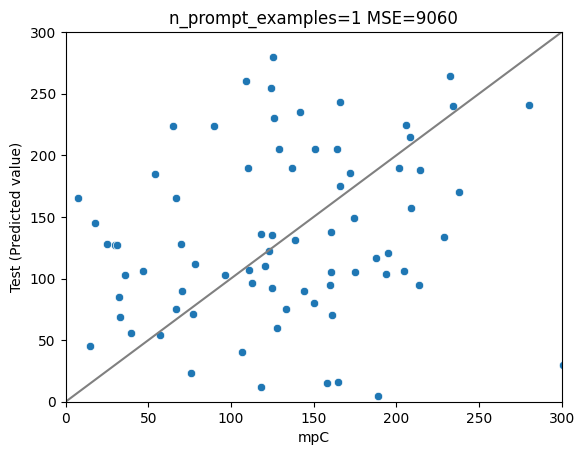

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

vmin=0
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    plt.savefig(f"results/llama{model_size}_n_prompt_examples={n_prompt_examples}_train={do_train}.png")
    #break

In [ ]:
print(prompt)


#Example Data
##Name: (3E)-3-(2-oxocyclopentylidene)-1,3-dihydro-2H-indol-2-one
##SMILES: O=C1Nc2ccccc2C1=C1CCCC1=O 
##Reason: The compound in question contains multiple functional groups that influence its melting point. The basic structure is that of an indole, which is fused to a cyclopentanone. To estimate the melting point, we start with the known melting point of a simple indole derivative, such as indole itself, which has a melting point of about 52°C. Cyclopentanone has a relatively high melting point for a ketone, around 49°C, due to the ring strain and dipole-dipole interactions. When these two structures are fused, the rigidity of the resulting system could significantly increase the melting point. Moreover, the compound has two carbonyl groups, which are capable of hydrogen-bonding and dipole-dipole interactions, likely to substantially raise the melting point compared to indole or cyclopentanone alone. Additionally, the (E)-configuration of the C=C double bond also contri